In [13]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from PIL import Image, ImageDraw, ImageFilter
import cv2
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

In [14]:
'''
Load and prepare the images
'''
## Load the images
source  = Image.open(r"C:\Users\trym7\OneDrive - UiT Office 365\skole\FYS-2010\Mandetory\Supplementary data\airplane.png") #foreground
target1 = Image.open(r"C:\Users\trym7\OneDrive - UiT Office 365\skole\FYS-2010\Mandetory\Supplementary data\sunny-sky.png") #background
target2 = Image.open(r"C:\Users\trym7\OneDrive - UiT Office 365\skole\FYS-2010\Mandetory\Supplementary data\mountain.png") #background
mask    = Image.open(r"C:\Users\trym7\OneDrive - UiT Office 365\skole\FYS-2010\Mandetory\Supplementary data\mask.png") # alpha mask

## Convert the images to numpy arrays
source = np.array(source)
target1 = np.array(target1)
target2 = np.array(target2)
mask   = np.array(mask)

In [20]:
'''
Pre-process the images
'''
#################################################################
######### Reduce scale_factor to improve program speed ##########
###### This will also reduce the resolution of your images ######
#################################################################
scale_factor = 1
#################################################################
#################################################################

## Scale down the images for faster runtime
if scale_factor < 1:
    source = cv2.resize(source, (0,0), fx=scale_factor,fy=scale_factor)
    target1 = cv2.resize(target1, (0,0), fx=scale_factor,fy=scale_factor)
    target2 = cv2.resize(target2, (0,0), fx=scale_factor,fy=scale_factor)
    mask = cv2.resize(mask, (0,0), fx=scale_factor,fy=scale_factor)

## Convert the mask to a 2D boolean array
mask = mask.astype(bool)

In [16]:
def remove_axes(ax:Axes) -> Axes:
    '''
    Edit an axes object to remove the axes ticks.
    '''
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)


def plot_composites(comp1:np.ndarray, comp2:np.ndarray, figtitle:str=""):
    '''
    Plot two composites side-by-side.
    '''
    fig,ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].imshow(comp1)
    ax[1].imshow(comp2)

    fig.suptitle(figtitle)
    for a in ax.ravel(): remove_axes(a)
    plt.tight_layout()

    return fig,ax

Fill the following function, `basicComposite()`, as part of answering part (a).

Text(0.75, 0.05, ' b)Hard edge composites')

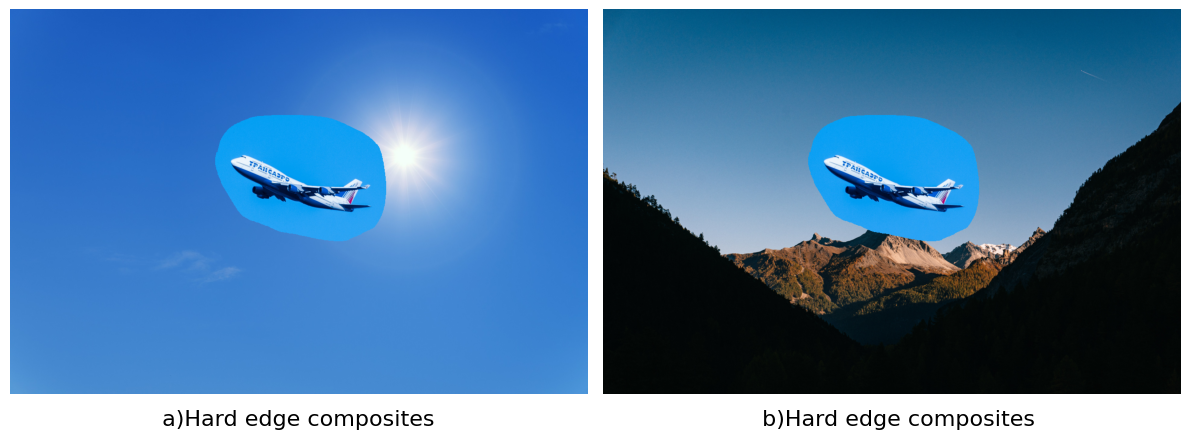

In [57]:
def basicComposite(source:np.ndarray, target:np.ndarray, mask:np.ndarray) -> np.array:
    '''
    Performs simple, hard-edge compositing.

    Arguments: 
        source (numpy array, uint8) : source image
        target (numpy array, uint8) : targete image
        mask (numpy array, bool) : boolean compositing mask

    Returns:
        comp (numpy array, uint8) : composite image
    '''

    #################################################################
    ################## Change the code in this box ##################
    #################################################################
    
    comp = np.copy(target)  
    mask = np.expand_dims(mask, axis=2)
    comp = source * mask + (1 - mask)*target # replace the pixels in the target image with the pixels in the source image where the mask is True
    
    #################################################################
    #################################################################
    #################################################################

    return comp.astype(np.uint8)


## Generate the basic composite image
hard_comp_1 = basicComposite(source, target1, mask)
hard_comp_2 = basicComposite(source, target2, mask)

## Save the basic composite image
Image.fromarray(hard_comp_1).save("./hardcomp-sky.png")
Image.fromarray(hard_comp_2).save("./hardcomp-mountain.png")

## Visualize the basic composite image
fig1,ax1 = plot_composites(hard_comp_1, hard_comp_2)
fig1.text(0.25, 0.05, " a)Hard edge composites", ha="center", va="center", fontsize=16)
fig1.text(0.75, 0.05, " b)Hard edge composites", ha="center", va="center", fontsize=16)

Fill the following function, `smoothComposite()`, as part of answering part (b).

In [80]:
def smoothComposite(source:np.ndarray, target:np.ndarray, mask:np.ndarray) -> np.array:
    '''
    Produces a composite image with a smooth composite border.

    Arguments: 
        source (numpy array, uint8) : source image
        target (numpy array, uint8) : targete image
        maks (numpy array, bool) : boolean compositing mask

    Returns:
        comp (numpy array, uint8) : composite image
    '''

    #################################################################
    ################## Change the code in this box ##################
    #################################################################

    comp = np.copy(target)
    mask = np.expand_dims(mask, axis=2) # expand the mask array along a new axis
    mask = cv2.GaussianBlur(mask.astype(np.float32), (7,7), 0) # blur the mask
    
    comp = source * mask + (1 - mask)*target # replace the pixels in the target image with the pixels in the source image where the mask is True

    

    #################################################################
    #################################################################
    #################################################################

    return comp.astype(np.uint8)



## Generate the smooth-edge composites
smooth_comp_1 = smoothComposite(source, target1, mask)
smooth_comp_2 = smoothComposite(source, target2, mask)

## Save the smooth-edge composites
Image.fromarray(smooth_comp_1).save("./smoothcomp-sky.png")
Image.fromarray(smooth_comp_2).save("./smoothcomp-mountain.png")

## Visualize the smooth-edge composites
fig2,ax2 = plot_composites(smooth_comp_1, smooth_comp_2, "Smooth edge composites")

ValueError: operands could not be broadcast together with shapes (799,1200,3) (799,1200) 

Fill the following function, `populateRow()`, as part of answering part (e).

C:\Users\trym7\AppData\Local\Temp\ipykernel_11728\633325655.py:1: DeprecationWarning: Please use `lil_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.lil` namespace is deprecated.
  def populateRow(A:sparse.lil.lil_matrix, b:np.ndarray, mask:np.ndarray,


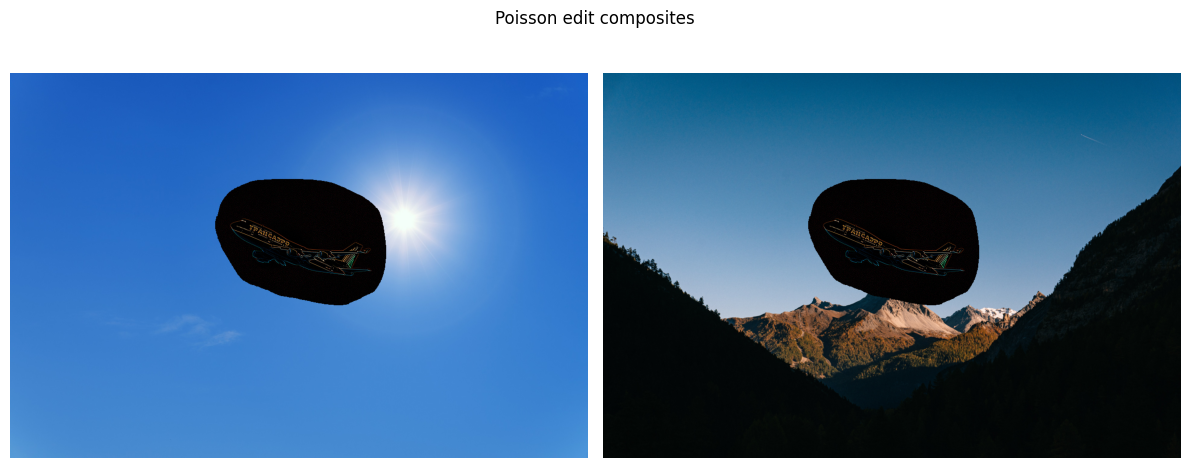

In [19]:
def populateRow(A:sparse.lil.lil_matrix, b:np.ndarray, mask:np.ndarray, 
                target:np.ndarray, ix:int, r:int, c:int, tup2idx:dict) -> np.ndarray:
    '''
    Populate row "ix" of the coeficient matrix "A".

    Arguments:
        - A (scipy sparse matrix): The square coeficient matrix.
        - b (numpy array): the right-hand-side vector of the sparse 
            linear system.
        - mask (numpy array): the boolean 2D array defining the 
            composite mask.
        - target (numpy array): the target image.
        - ix (int): the row of "A" being populated, also the index 
            of the corresponding pixel within the composite mask.
        - r (int): row coordinate of the pixel corresponding to row 
            "ix".
        - c (int): column coordinate of the pixel corresponding to 
            row "ix" of matrix "A".
        - tup2idx (dict): dictionary mapping the tuple (r,c) to the 
            corresponding pixel index "ix".

    Returns:
        - A (scipy sparse matrix): The square coefficient matrix,
            now with row "ix" populated.
    '''

    #################################################################
    ################## Change the code in this box ##################
    #################################################################

    A[ix,ix] = 1

    #################################################################
    #################################################################
    #################################################################

    return A





def poissonComposite(source:np.ndarray, target:np.ndarray, mask:np.ndarray) -> np.ndarray:
    '''
    Poisson Editing composite function.

    Arguments:
        source (numpy array) : source image
        target (numpy array) : target image
        mask (numpy array) : compositing mask

    Returns:
        (numpy array) : Poisson edit compossited image
    '''

    ## Initialize the composite as the target image
    comp = np.copy(target).astype(np.float64)

    ## Initialize the sparse matrix and right-hand-side of the linear system
    #  for a number of equations equal to the number of pixels within the 
    #  compositing mask
    A = sparse.lil_matrix((mask.sum(), mask.sum()))
    b = np.zeros((mask.sum(),3))

    ## Compute the laplacian of the source image, representing
    #  the divergence of the guidance vector field that is the 
    #  source image gradient
    laplace_filter = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    Ls = cv2.filter2D(source, kernel=laplace_filter, ddepth=cv2.CV_64F)

    ## Identify the coordinates of all pixels within the mask and a mapping to 
    #  the row indices of the sparse matrix
    mask_rows,mask_cols = np.where(mask)
    tup2idx = {(r,c):ix for ix,(r,c) in enumerate(zip(mask_rows,mask_cols))}

    ## Initialize right-hand-side of linear system
    b = Ls[mask_rows, mask_cols, :]

    ## Loop through each pixel within the mask to populate the sparse matrix A
    for ix,(r,c) in enumerate(zip(mask_rows,mask_cols)):
        A = populateRow(A, b, mask, target, ix, r,c, tup2idx)

    ## Solve the linear system
    A = sparse.csc_matrix(A)
    x0 = spsolve(A, b[:,0])
    x1 = spsolve(A, b[:,1])
    x2 = spsolve(A, b[:,2])

    ## Fill in the mask with the solved pixel values
    comp[mask_rows, mask_cols, 0] = x0
    comp[mask_rows, mask_cols, 1] = x1
    comp[mask_rows, mask_cols, 2] = x2

    ## Clip the final output to the range [0,255] and convert it
    #  to an 8-bit integer datatype
    comp = np.clip(comp, 0,255).astype(np.uint8)

    return comp




## Generate the Poisson edit composites
poisson_comp_1 = poissonComposite(source, target1, mask)
poisson_comp_2 = poissonComposite(source, target2, mask)

## Save the composites
Image.fromarray(poisson_comp_1).save("./poissoncomp-sky.png")
Image.fromarray(poisson_comp_2).save("./poissoncomp-mountain.png")

## Visualize the composites
fig3,ax3 = plot_composites(poisson_comp_1, poisson_comp_2, "Poisson edit composites")